In [1]:
import copy
import gym_blender
import gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import RMSprop

import numpy as np
% matplotlib inline

Using Theano backend.
Using gpu device 0: GeForce GTX 1070 (CNMeM is disabled, cuDNN 5110)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [6]:
# Deep-Q learning Agent
class DQNAgent:
    def __init__(self, env, image_dim):
        self.env = env
        self.memory = []
        self.gamma = 0.9  # decay rate
        self.epsilon = 1.0  # exploration
        self.epsilon_decay = .997
        self.epsilon_min = 0.1
        self.learning_rate = 0.0001
        self.image_dim = image_dim
        self.model = self._build_2dconv_model()
        
    def _build_2dconv_model(self):
        model = Sequential()
        # input:  images with 1 channels -> (x, y, 1) tensors.
        # this applies 32 convolution filters of size 3x3 each.
        print(self.image_dim)
        model.add(Conv2D(32, 3, 3, activation='relu', input_shape=self.image_dim))
        model.add(Conv2D(32, 3, 3, activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, 3, 3, activation='relu'))
        model.add(Conv2D(64, 3, 3, activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(4, activation='softmax'))

        rms = RMSprop(lr=self.learning_rate)
        model.compile(loss='categorical_crossentropy', optimizer=rms)
        
        return model
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return self.env.action_space.sample()
        act_values = self.model.predict(state)
        
        return np.argmax(act_values[0])  # returns action
    
    def replay(self, batch_size):
        print('training')
        batches = min(batch_size, len(self.memory))
        batches = np.random.choice(len(self.memory), batches)
        for i in batches:
            state, action, reward, next_state, done = self.memory[i]
            target = reward
            if not done:
                target = reward + self.gamma * \
                       np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, nb_epoch=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [7]:
ridge_env = gym.envs.make('ridge-v0')

state = ridge_env._reset()
state = np.expand_dims(state, 0)
agent = DQNAgent(ridge_env, state.shape)

episodes = 10000
# Iterate the game
for e in range(episodes):

    # reset state in the beginning of each game
    state = ridge_env._reset()
    state = np.expand_dims(np.expand_dims(state, 0), 0)
    # time_t represents each frame of the game
    # Our goal is to keep the pole upright as long as possible
    # the more time_t the more score
    for time_t in range(5000):
        # turn this on if you want to render
        # env.render()

        # Decide action
        action = agent.act(state)

        # Advance the game to the next frame based on the action.
        next_state, reward, done, _ = ridge_env.step(ridge_env.blender_interface.legal_action_set[action])

        # (reward defaults to 1)
        # reward the agent 1 for every frame it lived
        # and punish -100 for dying
        reward = -100 if done else 1
        
        next_state = np.expand_dims(np.expand_dims(next_state, 0), 0)
        # Remember the previous state, action, reward, and done
        agent.remember(state, action, reward, next_state, done)

        # make next_state the new current state for the next frame.
        state = copy.deepcopy(next_state)

        # done becomes True when the game ends
        # ex) The agent drops the pole
        if done:
            # print the score and break out of the loop
            print("episode: {}/{}, score: {}"
                  .format(e, episodes, time_t))
            break
    # train the agent with the experience of the episode
    agent.replay(32)
    
del agent.env
del ridge_env

[2017-05-20 21:26:05,682] Making new env: ridge-v0


starting
UDP started
(1, 54, 321)
episode: 0/10000, score: 29
training
episode: 1/10000, score: 39
training
episode: 2/10000, score: 86
training
episode: 3/10000, score: 35
training
episode: 4/10000, score: 26
training
episode: 5/10000, score: 19
training
episode: 6/10000, score: 30
training
episode: 7/10000, score: 29
training
episode: 8/10000, score: 77
training
episode: 9/10000, score: 32
training
episode: 10/10000, score: 42
training
episode: 11/10000, score: 44
training
episode: 12/10000, score: 42
training
episode: 13/10000, score: 53
training
episode: 14/10000, score: 99
training
episode: 15/10000, score: 103
training
episode: 16/10000, score: 16
training
episode: 17/10000, score: 35
training
episode: 18/10000, score: 24
training
episode: 19/10000, score: 62
training
episode: 20/10000, score: 26
training
episode: 21/10000, score: 23
training
episode: 22/10000, score: 59
training
episode: 23/10000, score: 31
training
episode: 24/10000, score: 28
training
episode: 25/10000, score:

KeyboardInterrupt: 

In [12]:
agent.memory[0][0][0,0,...].shape

(54, 321)

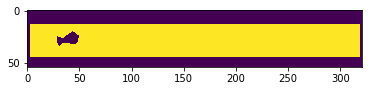

In [15]:
plt.imshow(agent.memory[0][0][0,0,...])
plt.show()

In [5]:
agent.epsilon

0.0996820918179746